# Estimating car values

A used car sales service is developing an application to attract new customers. In this app, users can quickly determine the market value of their car. Historical data is available, including technical specifications, configurations and prices of cars. You need to build a model to estimate the car's value.

The client prioritizes:

- Prediction accuracy
- Prediction speed
- Training time

## Data preparation

In [50]:
pip install lightgbm

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import statsmodels.api as sm
import seaborn as sns 
import lightgbm as lgb
import phik
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [52]:
sns.set()

*Data analysis and preparation*

In [53]:
df = pd.read_csv('autos.csv')
df.columns = df.columns.str.lower()

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [55]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


*Duplicates check*

In [56]:
df.duplicated().sum()

4

In [57]:
df.drop_duplicates(inplace=True)

*table field "numberofpictures" is empty, it is removed*

In [58]:
df['numberofpictures'].unique()

array([0], dtype=int64)

*Check and vizualize features*

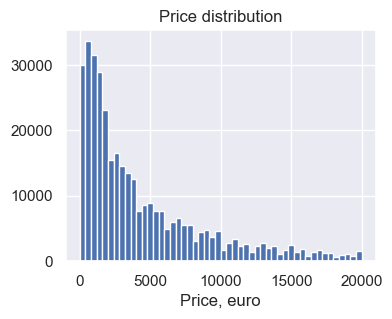

In [59]:
plt.figure(figsize=(4,3))
df['price'].hist(bins=50)
plt.title('Price distribution')
plt.xlabel('Price, euro')
plt.show()

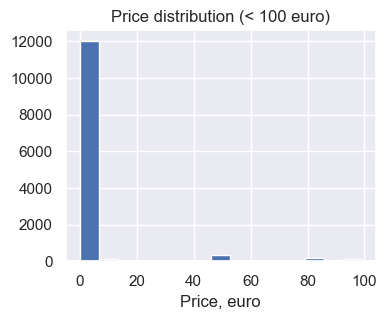

In [60]:
plt.figure(figsize=(4,3))
df['price'][df['price'] < 100].hist(bins=15)
plt.title('Price distribution (< 100 euro)')
plt.xlabel('Price, euro')
plt.show()

*From the graph, it can be seen that data with prices below 50 euros can be safely removed. Most likely, they represent scrap metal because the cost of disposal is higher.*

In [61]:
np.percentile(df['price'],3.5)

45.0

In [62]:
df = df[df['price'] >= 50]

*3.5% of data is removed* 

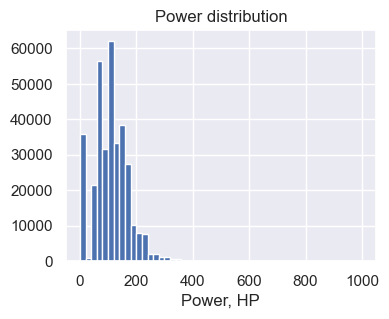

In [63]:
plt.figure(figsize=(4,3))
df['power'][df['power'] < 1000].hist(bins=50)
plt.title('Power distribution')
plt.xlabel('Power, HP')
plt.show()

*There are inconsistencies in the data, for example, a power value of 20,000 is clearly an exaggeration. Therefore, we will exclude anything above 400 horsepower. For example, the Land Cruiser and Cherokee have power ranging from 300 to 350 horsepower, assuming some may have turbochargers. If there are outliers like the Ferrari LaFerrari with 950 horsepower in the dataset, they will distort the relationship for popular cars. Additionally, we have an excessive number of low-power vehicles, so we will set a cutoff at 25 horsepower.*

*Next, the minimum registration year is currently set at 1000, which may be unrealistic unless it's a historical vehicle of the King Arthur. We need to set a new minimum threshold for the date. Similarly, the maximum year is set at 9999, which is not practical, so we will limit it to 2022. Afterward, we will create a histogram to determine the minimum threshold. Additionally, we will remove the column with the number of photos.*

In [64]:
df = df.drop('numberofpictures', axis=1)

In [65]:
df = df[df['registrationyear'] < 2023]

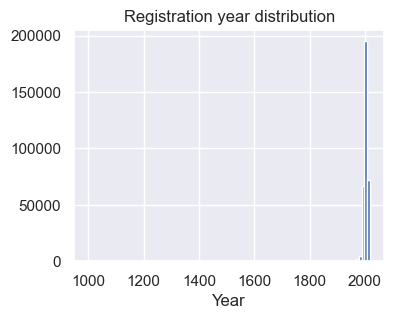

In [66]:
plt.figure(figsize=(4,3))
df['registrationyear'].hist(bins=100)
plt.title('Registration year distribution')
plt.xlabel('Year')
plt.show()

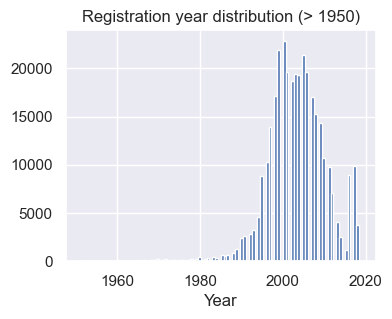

In [67]:
plt.figure(figsize=(4,3))
df['registrationyear'][df['registrationyear'] > 1950].hist(bins=100)
plt.title('Registration year distribution (> 1950)')
plt.xlabel('Year')
plt.show()

*The graph shows that the proper range is 1960-2019*

In [68]:
df = df[(df['registrationyear'] >= 1960) & (df['registrationyear'] < 2020)]

DateCrawled — date of downloading the questionnaire from the database

In [69]:
df.datecrawled = pd.to_datetime(df.datecrawled)

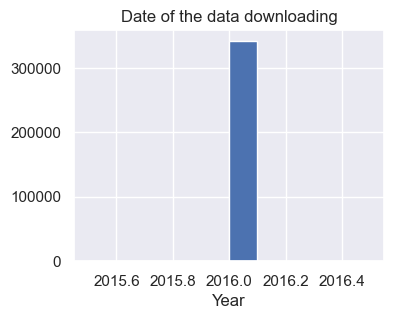

In [70]:
plt.figure(figsize=(4,3))
df.datecrawled.dt.year.hist()
plt.title('Date of the data downloading')
plt.xlabel('Year')
plt.show()

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341550 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        341550 non-null  datetime64[ns]
 1   price              341550 non-null  int64         
 2   vehicletype        308727 non-null  object        
 3   registrationyear   341550 non-null  int64         
 4   gearbox            325058 non-null  object        
 5   power              341550 non-null  int64         
 6   model              324544 non-null  object        
 7   kilometer          341550 non-null  int64         
 8   registrationmonth  341550 non-null  int64         
 9   fueltype           312990 non-null  object        
 10  brand              341550 non-null  object        
 11  repaired           276896 non-null  object        
 12  datecreated        341550 non-null  object        
 13  postalcode         341550 non-null  int64   

In [72]:
df = df[(df['power'] > 24) & (df['power'] <= 400)]

*Let's examine the missing values. We will calculate the percentage of missing values for each column in relation to the total dataset.*

In [73]:
df.isna().sum() / len(df) * 100

datecrawled           0.000000
price                 0.000000
vehicletype           6.897772
registrationyear      0.000000
gearbox               1.947988
power                 0.000000
model                 3.951699
kilometer             0.000000
registrationmonth     0.000000
fueltype              6.377260
brand                 0.000000
repaired             15.249898
datecreated           0.000000
postalcode            0.000000
lastseen              0.000000
dtype: float64

*It will be difficult to reconstruct the model, so we will remove the missing values and columns that are not needed.*

In [74]:
df.dropna(subset=['model'], inplace=True)

*Let's get rid of the data that is not related to pricing. But first, let's consider the postal code as a distinctive feature. If we are referring to Russia, the first three digits represent the subject of the federation. Therefore, we will keep only the first three digits.*

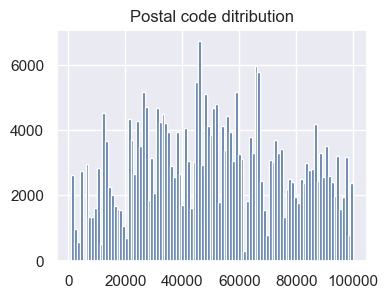

In [75]:
plt.figure(figsize=(4,3))
df['postalcode'].hist(bins=100)
plt.title('Postal code ditribution')
plt.show()

In [76]:
def f(x):
    return int(str(x)[:3])

In [77]:
df['postalcode'] = df['postalcode'].apply(f)

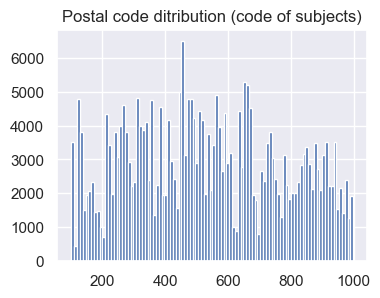

In [78]:
plt.figure(figsize=(4,3))
df['postalcode'].hist(bins=100)
plt.title('Postal code ditribution (code of subjects)')
plt.show()

In [79]:
df.drop(['datecrawled','lastseen','datecreated'],axis=1, inplace=True)

In [80]:
df.isna().sum() / len(df) * 100

price                 0.000000
vehicletype           6.236264
registrationyear      0.000000
gearbox               1.768090
power                 0.000000
model                 0.000000
kilometer             0.000000
registrationmonth     0.000000
fueltype              5.516538
brand                 0.000000
repaired             14.458345
postalcode            0.000000
dtype: float64

*We have removed about 5%, but there are still quite a lot of omissions. Now we will remove the gearbox since it is only 1.7%, and the criterion is very important and filling with distortions is unacceptable. Next, fill in the gaps in the fuel type*

In [81]:
df.dropna(subset=['gearbox'],inplace=True)

In [82]:
df['fueltype'].value_counts()

petrol      181329
gasoline     86274
lpg           4440
cng            476
hybrid         180
other           68
electric        34
Name: fueltype, dtype: int64

*Replace gasoline as petrol*

In [83]:
df.loc[df.fueltype == 'gasoline', 'fueltype'] = 'petrol'

In [84]:
df['fueltype'].value_counts(normalize=True)

petrol      0.980946
lpg         0.016276
cng         0.001745
hybrid      0.000660
other       0.000249
electric    0.000125
Name: fueltype, dtype: float64

*It can be seen that more than 98% of the total type of gasoline is petrol, so we will fill in the gaps with the most frequent value.*

In [85]:
 df['fueltype'].fillna( df['fueltype'].mode()[0],inplace=True)

In [86]:
df.isna().sum() / len(df) * 100

price                 0.000000
vehicletype           5.818716
registrationyear      0.000000
gearbox               0.000000
power                 0.000000
model                 0.000000
kilometer             0.000000
registrationmonth     0.000000
fueltype              0.000000
brand                 0.000000
repaired             13.922674
postalcode            0.000000
dtype: float64

*After attempting to encode the categorical features, it becomes evident that there are too many categories for one-hot encoding. Therefore, we will use the LabelEncoder, even though it may introduce distortions compared to binary encoding. As for the "repaired/unrepaired" parameter, we will replace the missing values with "unknown" since this parameter is crucial.*

In [87]:
df['repaired'].fillna('unknown',inplace=True)

*Split dataset*

In [88]:
features = df.drop('price', axis=1)
target = df['price']

*Fill omissions as 'unknown'*

In [89]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287847 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicletype        271098 non-null  object
 1   registrationyear   287847 non-null  int64 
 2   gearbox            287847 non-null  object
 3   power              287847 non-null  int64 
 4   model              287847 non-null  object
 5   kilometer          287847 non-null  int64 
 6   registrationmonth  287847 non-null  int64 
 7   fueltype           287847 non-null  object
 8   brand              287847 non-null  object
 9   repaired           287847 non-null  object
 10  postalcode         287847 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 26.4+ MB


In [90]:
features.loc[features.vehicletype.isna(),'vehicletype'] = 'unknown'

In [91]:
feature_train, feature_valid, target_train, target_valid = train_test_split(features,
                                                                          target,
                                                                          test_size=.4,
                                                                          random_state=123
                                                                          )
feature_test, feature_valid, target_test, target_valid = train_test_split(feature_valid,
                                                                          target_valid,
                                                                          test_size=.5,
                                                                          random_state=123
                                                                          )

In [92]:
column = ['vehicletype','gearbox','model','fueltype','brand','repaired']
oe = OrdinalEncoder()
feature_train[column] = oe.fit_transform(feature_train[column])
feature_valid[column] = oe.transform(feature_valid[column])
feature_test[column] = oe.transform(feature_test[column])

In [93]:
feature_train = feature_train.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)

In [94]:
target_df = pd.DataFrame(data=target_train,columns=['price'])

*Let's check the data for anomalies or outliers.*

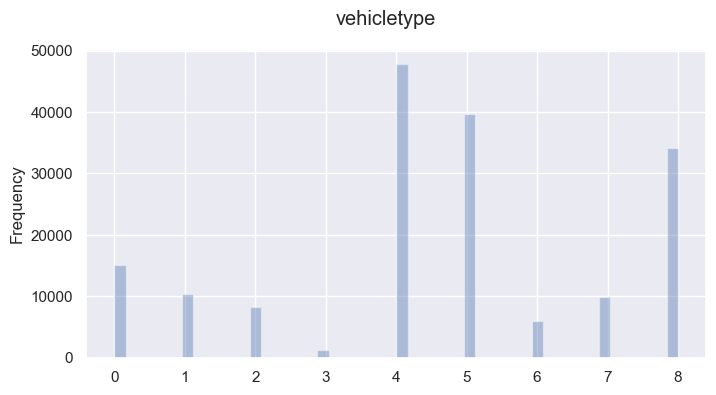

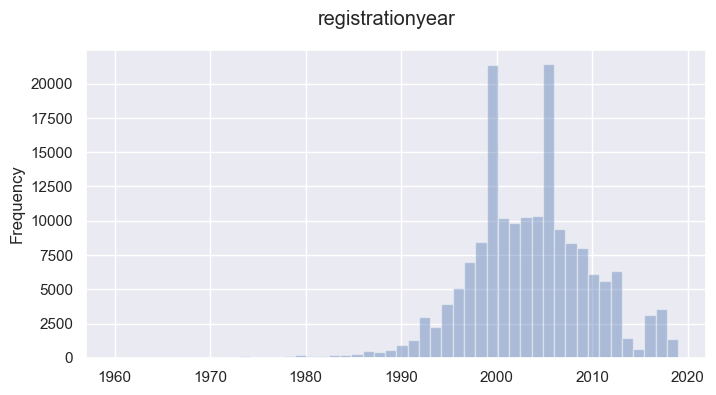

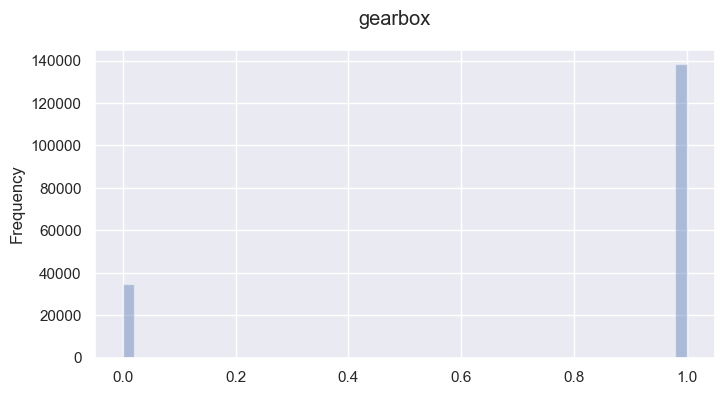

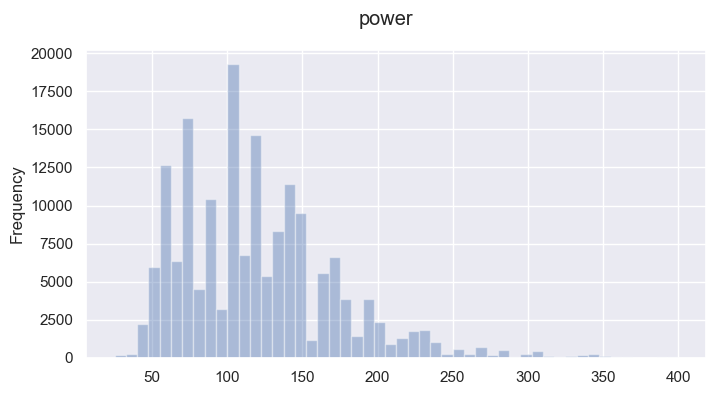

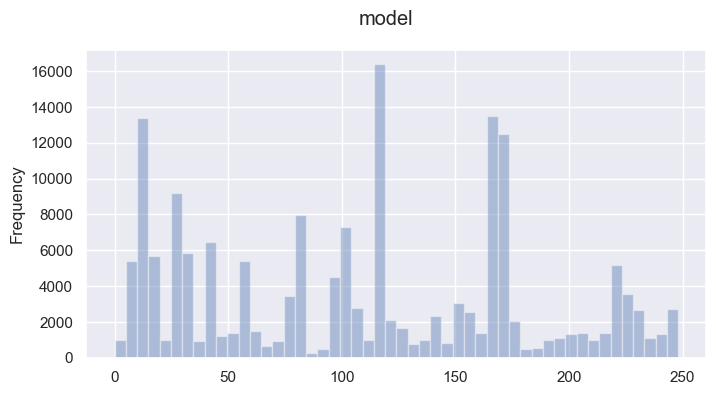

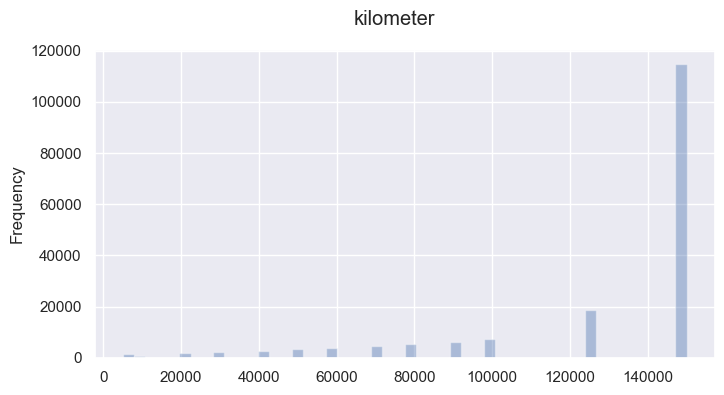

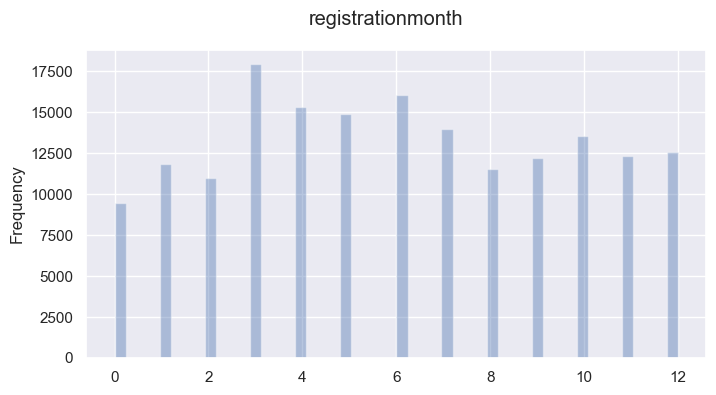

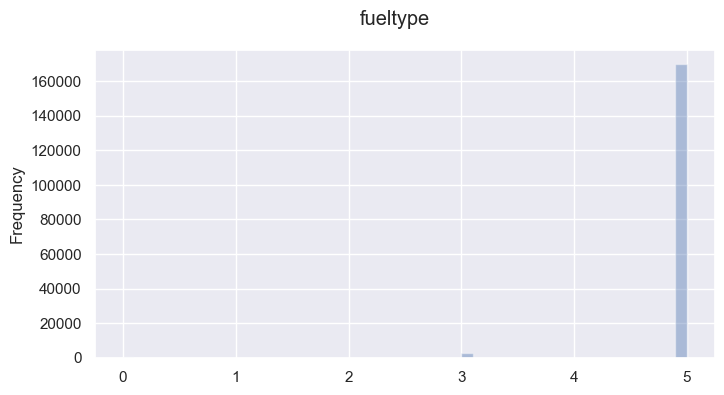

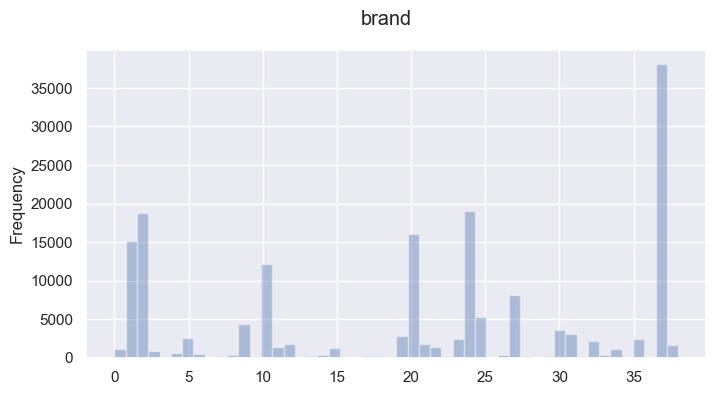

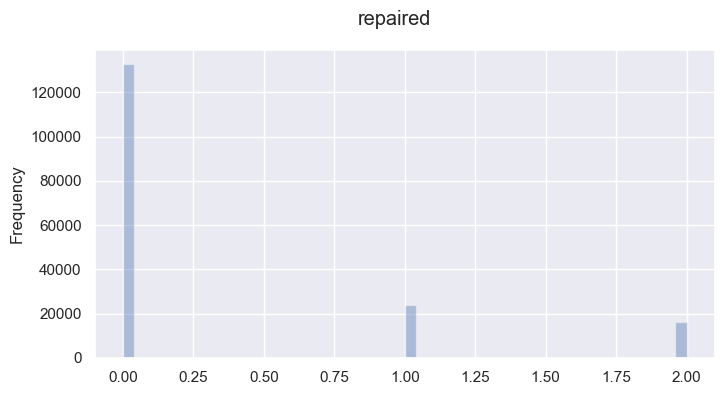

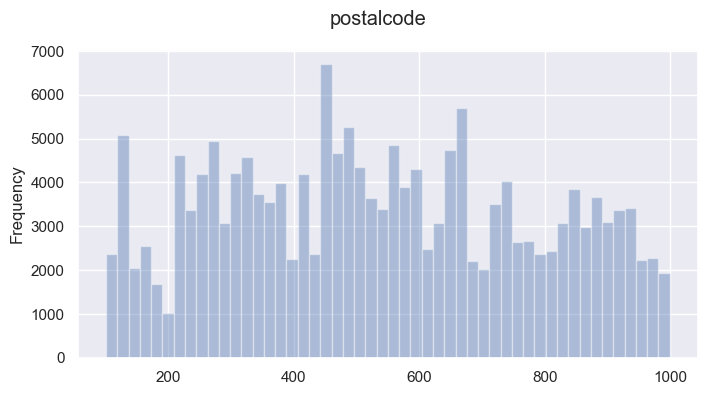

In [95]:
for column in feature_train.columns: 
    fig, axes = plt.subplots(1, 1, figsize=(8, 4))
    plt.suptitle(column)
    feature_train[column].plot(kind="hist",bins=50, color='b', alpha=0.4,ax=axes)
    plt.show()

interval columns not set, guessing: ['vehicletype', 'registrationyear', 'gearbox', 'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand', 'repaired', 'postalcode', 'price']


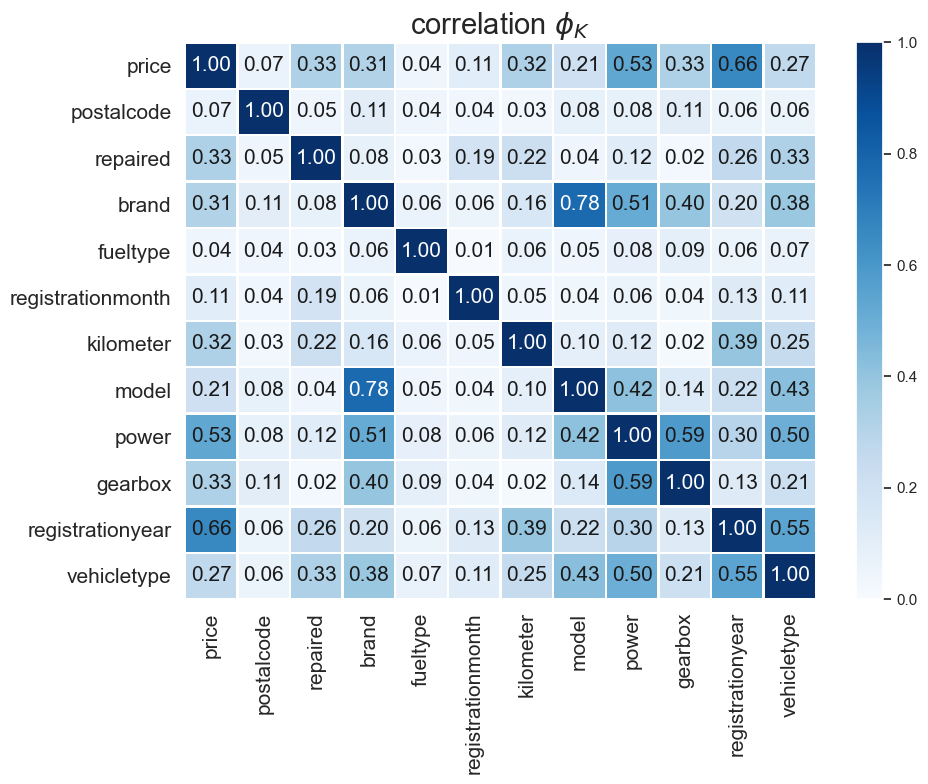

In [96]:
phik_overview = pd.concat([feature_train,target_df],axis=1).phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

*The correlation matrix shows that the fuel type and postal code are almost not correlated with the price, so we will delete them as well*

In [97]:
feature_train.drop(['fueltype','postalcode'],axis=1, inplace=True)
feature_valid.drop(['fueltype','postalcode'],axis=1, inplace=True)
feature_test.drop(['fueltype','postalcode'],axis=1, inplace=True)

In [98]:
(feature_train.shape[0] + feature_test.shape[0] + feature_valid.shape[0])/ 354369 * 100

81.22804195626593

**Conclusion: during data processing, we filled in the gaps where possible and deleted incorrect data. As a result, we are dealing with 81% of the original population, which was the result of data cleansing. In general, the data have been prepared, of the remaining anomalies, it is worth emphasizing the strange distribution in the year of registration - peaks in 2000 and 2005.**

*Scaling features*

In [99]:
feature_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,brand,repaired
0,4.0,2007,0.0,231,15.0,150000,1,2.0,0.0
1,5.0,2004,1.0,60,128.0,80000,4,10.0,0.0
2,2.0,2001,0.0,163,59.0,150000,5,20.0,0.0
3,5.0,1992,1.0,45,173.0,20000,8,37.0,2.0
4,4.0,2000,1.0,150,15.0,150000,10,2.0,0.0


In [100]:
columns = ['vehicletype','registrationyear','power','model','kilometer','brand','repaired','registrationmonth'] 
scale = MinMaxScaler()
scale.fit(feature_train[columns])
feature_train[columns] = scale.transform(feature_train[columns])

In [101]:
feature_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,brand,repaired
0,0.500,0.796610,0.0,0.549333,0.060484,1.000000,0.083333,0.052632,0.0
1,0.625,0.745763,1.0,0.093333,0.516129,0.517241,0.333333,0.263158,0.0
2,0.250,0.694915,0.0,0.368000,0.237903,1.000000,0.416667,0.526316,0.0
3,0.625,0.542373,1.0,0.053333,0.697581,0.103448,0.666667,0.973684,1.0
4,0.500,0.677966,1.0,0.333333,0.060484,1.000000,0.833333,0.052632,0.0


In [102]:
feature_valid[columns] = scale.transform(feature_valid[columns])
feature_test[columns] = scale.transform(feature_test[columns])

## Model training

*By the condition of the task, the research metric is RMSE, we declare the function*

In [103]:
def RMSE(test, predict):
    return round(mean_squared_error(test, predict)**.5, 3)

*Let's start with the simplest* **linear regressor**

In [104]:
%%time
model_lr = LinearRegression()
model_lr.fit(feature_train, target_train)

CPU times: total: 141 ms
Wall time: 255 ms


LinearRegression()

In [105]:
%%time
predict_lr = model_lr.predict(feature_valid)

CPU times: total: 0 ns
Wall time: 10 ms


In [106]:
RMSE(predict_lr,target_valid)

2983.742

*Train* **random forest**

In [107]:
%%time
model_rf = RandomForestRegressor(random_state=123, n_estimators=70)
model_rf.fit(feature_train, target_train)

CPU times: total: 57.2 s
Wall time: 57.3 s


RandomForestRegressor(n_estimators=70, random_state=123)

In [108]:
%%time
pred_rf=model_rf.predict(feature_valid)

CPU times: total: 2.36 s
Wall time: 2.35 s


In [109]:
RMSE(pred_rf,target_valid)

1590.534

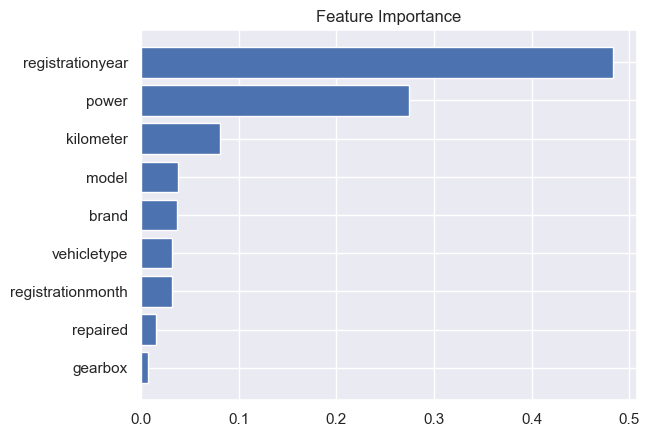

In [110]:
sort = model_rf.feature_importances_.argsort()
plt.barh(feature_train.columns[sort], model_rf.feature_importances_[sort])
plt.title("Feature Importance")
plt.show()

*Train* **LightGMB**

In [111]:
%%time
model_lgb = LGBMRegressor(n_estimators=70, random_state=123, objective='RMSE')
model_lgb.fit(feature_train, target_train)

CPU times: total: 3.28 s
Wall time: 1.04 s


LGBMRegressor(n_estimators=70, objective='RMSE', random_state=123)

In [112]:
%%time
pred_lgb=model_lgb.predict(feature_valid)

CPU times: total: 516 ms
Wall time: 82 ms


In [113]:
RMSE(pred_lgb,target_valid)

1719.154

In [114]:
%%time
model_lgb = LGBMRegressor(n_estimators=200, random_state=123, objective='RMSE')
model_lgb.fit(feature_train, target_train)

CPU times: total: 7.22 s
Wall time: 1.07 s


LGBMRegressor(n_estimators=200, objective='RMSE', random_state=123)

In [115]:
%%time
pred_lgb=model_lgb.predict(feature_valid)

CPU times: total: 938 ms
Wall time: 154 ms


In [116]:
RMSE(pred_lgb,target_valid)

1621.944

In [117]:
train_dataset = lgb.Dataset(feature_train, target_train)
valid_dataset = lgb.Dataset(feature_valid, target_valid, reference=train_dataset)

In [118]:
%%time
param = {'objective': 'rmse','metric': 'l2','max_depth':40,"random_state": 123,"learning_rate":0.1}
booster = lgb.train(param,
                    train_dataset,
                    num_boost_round=1000,
                    valid_sets=[train_dataset, valid_dataset],
                    verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\79609\anaconda3\envs\ds_practicum_env\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 172708, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 4904.779495
[100]	training's l2: 2.72319e+06	valid_1's l2: 2.82047e+06
[200]	training's l2: 2.44372e+06	valid_1's l2: 2.6307e+06
[300]	training's l2: 2.28385e+06	valid_1's l2: 2.53952e+06
[400]	training's l2: 2.17184e+06	valid_1's l2: 2.48628e+06
[500]	training's l2: 2.08309e+06	valid_1's l2: 2.44848e+06
[600]	training's l2: 2.01063e+06	va

In [119]:
%%time
pred_booster=booster.predict(feature_valid)

CPU times: total: 4.72 s
Wall time: 679 ms


In [120]:
RMSE(pred_booster,target_valid)

1532.947

## Model analysis

*According to the task requirements and criteria that are important to the client:*

- Prediction quality
- Model training time
- Model prediction time

*As expected, the LightGBM model achieved the highest accuracy with an RMSE of 1532. However, it required the longest training time of over 7 minutes and 5 seconds for prediction. Random Forest showed a similar result of 1590 with a training time of 34 seconds. However, the selection of the model should consider a combination of speed and accuracy. Therefore, we will choose the Random Forest model.*

*Let's proceed with the testing.*

In [121]:
%%time
RMSE(model_rf.predict(feature_test),target_test)

CPU times: total: 2.5 s
Wall time: 2.43 s


1602.878

*The test showed a result close to the validation sample, which indicates that our model has not retrained, shows the necessary model quality and speed*